In [ ]:
# =========================================
# STEP 1: SETUP DRIVE
# =========================================
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

base_dir = "/content/drive/MyDrive/chest_xray_project"
os.makedirs(base_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================================
# STEP 2: KAGGLE API SETUP
# =========================================
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()   # 👉 Upload kaggle.json here

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# =========================================
# STEP 3: DOWNLOAD & UNZIP DATASETS
# =========================================
# Force full downloads
!rm -rf /content/COVID-19_Radiography_Dataset /content/Data
!rm -f /content/covid19-radiography-database.zip /content/chest-xray-covid19-pneumonia.zip

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content --force
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia -p /content --force

# Unzip main zips
!unzip -q /content/covid19-radiography-database.zip -d /content/
!unzip -q /content/chest-xray-covid19-pneumonia.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 98% 760M/778M [00:07<00:00, 187MB/s]
100% 778M/778M [00:07<00:00, 107MB/s]
Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
 99% 2.04G/2.06G [00:16<00:00, 46.6MB/s]
100% 2.06G/2.06G [00:16<00:00, 134MB/s] 


In [ ]:
# =========================================
# STEP 4: MERGE INTO 3 CLASSES
# =========================================
merged_dir = "/content/merged_dataset"
for cls in ["COVID", "PNEUMONIA", "NORMAL"]:
    os.makedirs(os.path.join(merged_dir, cls), exist_ok=True)

def copy_images(src_folder, dest_folder):
    if not os.path.exists(src_folder):
        return
    for img in os.listdir(src_folder):
        path = os.path.join(src_folder, img)
        if os.path.isfile(path) and img.lower().endswith(("png","jpg","jpeg")):
            shutil.copy(path, dest_folder)

# ---- Dataset 1: Radiography (note the /images subfolders!)
src1 = "/content/COVID-19_Radiography_Dataset"
copy_images(os.path.join(src1, "COVID/images"), os.path.join(merged_dir, "COVID"))
copy_images(os.path.join(src1, "Normal/images"), os.path.join(merged_dir, "NORMAL"))
copy_images(os.path.join(src1, "Viral Pneumonia/images"), os.path.join(merged_dir, "PNEUMONIA"))
copy_images(os.path.join(src1, "Lung_Opacity/images"), os.path.join(merged_dir, "PNEUMONIA"))

# ---- Dataset 2: Prashant (Data/train + Data/test)
src2 = "/content/Data"
for subset in ["train", "test"]:
    for cls in ["COVID19", "NORMAL", "PNEUMONIA"]:
        src_path = os.path.join(src2, subset, cls)
        if os.path.exists(src_path):
            cls_target = "COVID" if cls == "COVID19" else cls
            copy_images(src_path, os.path.join(merged_dir, cls_target))

# Check merged counts before balancing
covid_count = len(os.listdir(os.path.join(merged_dir, "COVID")))
pneu_count  = len(os.listdir(os.path.join(merged_dir, "PNEUMONIA")))
normal_count = len(os.listdir(os.path.join(merged_dir, "NORMAL")))
print("Before balancing:")
print("COVID:", covid_count, " PNEUMONIA:", pneu_count, " NORMAL:", normal_count)

Before balancing:
COVID: 4192  PNEUMONIA: 11630  NORMAL: 11775


In [ ]:
# =========================================
# STEP 5: BALANCE DATASET TO TARGET COUNTS
# =========================================
import uuid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import os

def augment_class(class_dir, target_count):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    current_count = len(images)
    needed = target_count - current_count

    if needed <= 0:
        print(f"{os.path.basename(class_dir)} already has {current_count}, no augmentation needed")
        return

    print(f"Augmenting {os.path.basename(class_dir)}: current={current_count}, target={target_count}, generating {needed} new images")

    i = 0
    while len(os.listdir(class_dir)) < target_count:
        img_path = os.path.join(class_dir, images[i % len(images)])
        img = tf.keras.utils.load_img(img_path, target_size=(224,224))
        x = tf.keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # unique filename using uuid
        for batch in datagen.flow(
            x, batch_size=1, save_to_dir=class_dir,
            save_prefix=str(uuid.uuid4()), save_format="png"
        ):
            break

        i += 1
        if i % 500 == 0:
            print(f"Generated {i} augmented images so far... current total={len(os.listdir(class_dir))}")

    print(f"✅ Finished augmentation for {os.path.basename(class_dir)}. Final count = {len(os.listdir(class_dir))}")


# Paths
covid_dir  = os.path.join(merged_dir, "COVID")
pneu_dir   = os.path.join(merged_dir, "PNEUMONIA")
normal_dir = os.path.join(merged_dir, "NORMAL")

# Target counts
target_covid  = 11775
target_pneu   = 11630
target_normal = 11775

# Augment each class
augment_class(covid_dir, target_covid)
augment_class(pneu_dir, target_pneu)
augment_class(normal_dir, target_normal)

print("\nFinal class counts after balancing:")
print("COVID:", len(os.listdir(covid_dir)))
print("PNEUMONIA:", len(os.listdir(pneu_dir)))
print("NORMAL:", len(os.listdir(normal_dir)))


Augmenting COVID: current=9490, target=11775, generating 2285 new images
Generated 500 augmented images so far... current total=9990
Generated 1000 augmented images so far... current total=10490
Generated 1500 augmented images so far... current total=10990
Generated 2000 augmented images so far... current total=11490
✅ Finished augmentation for COVID. Final count = 11775
PNEUMONIA already has 11630, no augmentation needed
NORMAL already has 11775, no augmentation needed

Final class counts after balancing:
COVID: 11775
PNEUMONIA: 11630
NORMAL: 11775


In [ ]:
# =========================================
# STEP 6: TRAIN/VAL/TEST SPLIT & SAVE TO DRIVE
# =========================================

# 1. Install split-folders (only once per Colab session)
!pip install split-folders

import splitfolders, os

# 2. Path to your merged balanced dataset
#    (must contain 3 folders: COVID, PNEUMONIA, NORMAL)
input_folder = merged_dir    # e.g. "/content/merged_dataset"

# 3. Output path (where train/val/test will be created)
output_folder = "/content/final_dataset"

# 4. Perform split (70% train, 15% val, 15% test)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.15, 0.15))

# 5. Copy final dataset to Google Drive
!cp -r /content/final_dataset "/content/drive/MyDrive/chest_xray_project/"

print("\n✅ Final dataset split into train/val/test and saved to Drive at: chest_xray_project/final_dataset")

# 6. Sanity check: Count images in each split/class
for split in ["train", "val", "test"]:
    for cls in ["COVID", "PNEUMONIA", "NORMAL"]:
        path = os.path.join(output_folder, split, cls)
        print(f"{split}/{cls} → {len(os.listdir(path))} images")


Copying files: 27597 files [00:41, 669.50 files/s] 


^C

✅ Final dataset split into train/val/test and saved to Drive at: chest_xray_project/final_dataset
train/COVID → 2934 images
train/PNEUMONIA → 8140 images
train/NORMAL → 8242 images
val/COVID → 628 images
val/PNEUMONIA → 1744 images
val/NORMAL → 1766 images
test/COVID → 630 images
test/PNEUMONIA → 1746 images
test/NORMAL → 1767 images


In [ ]:
import os

drive_path = "/content/drive/MyDrive/chest_xray_project/final_dataset"

for split in ["train", "val", "test"]:
    for cls in ["COVID", "PNEUMONIA", "NORMAL"]:
        path = os.path.join(drive_path, split, cls)
        print(split, cls, ":", len(os.listdir(path)))


train COVID : 10742
train PNEUMONIA : 10582
train NORMAL : 10723
val COVID : 3270
val PNEUMONIA : 3219
val NORMAL : 3275
test COVID : 3271
test PNEUMONIA : 3238
test NORMAL : 3272


In [ ]:
# =========================================
# STEP 7: LOAD DATA (from local copy of Drive dataset)
# =========================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Copy dataset from Drive -> Colab local storage (much faster for training)
!cp -r "/content/drive/MyDrive/chest_xray_project/final_dataset" /content/
dataset_dir = "/content/final_dataset"

# Image size and batch size
img_size = (224,224)
batch_size = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Only rescaling for validation & test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Validation generator
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Test generator
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\n✅ Generators ready")
print("Classes:", train_gen.class_indices)

Found 32047 images belonging to 3 classes.
Found 9764 images belonging to 3 classes.
Found 9781 images belonging to 3 classes.

✅ Generators ready
Classes: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
# =========================================
# STEP 8a: DENSENET201 TRAINING (fine-tuned, 15 epochs)
# =========================================
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load DenseNet201 backbone
densenet_base = DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze most layers, unfreeze last 50 for fine-tuning
for layer in densenet_base.layers[:-50]:
    layer.trainable = False
for layer in densenet_base.layers[-50:]:
    layer.trainable = True

# Classification head
x = densenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation="softmax")(x)

densenet_model = Model(inputs=densenet_base.input, outputs=predictions)

# Compile with smaller LR for fine-tuning
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5",
    monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# Train DenseNet201
history_densenet = densenet_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

densenet_model.save("/content/drive/MyDrive/chest_xray_project/densenet201_final_ft.h5")


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5523 - loss: 0.9502
Epoch 1: val_accuracy improved from -inf to 0.81186, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 610s 542ms/step - accuracy: 0.5525 - loss: 0.9500 - val_accuracy: 0.8119 - val_loss: 0.4728 - learning_rate: 1.0000e-05
Epoch 2/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7993 - loss: 0.5125
Epoch 2: val_accuracy improved from 0.81186 to 0.84125, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 450s 449ms/step - accuracy: 0.7993 - loss: 0.5125 - val_accuracy: 0.8413 - val_loss: 0.4020 - learning_rate: 1.0000e-05
Epoch 3/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8455 - loss: 0.4073
Epoch 3: val_accuracy improved from 0.84125 to 0.86092, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 452s 452ms/step - accuracy: 0.8455 - loss: 0.4073 - val_accuracy: 0.8609 - val_loss: 0.3599 - learning_rate: 1.0000e-05
Epoch 4/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8667 - loss: 0.3586
Epoch 4: val_accuracy improved from 0.86092 to 0.87956, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 453s 452ms/step - accuracy: 0.8667 - loss: 0.3586 - val_accuracy: 0.8796 - val_loss: 0.3119 - learning_rate: 1.0000e-05
Epoch 5/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8782 - loss: 0.3260
Epoch 5: val_accuracy improved from 0.87956 to 0.89830, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 454s 453ms/step - accuracy: 0.8782 - loss: 0.3260 - val_accuracy: 0.8983 - val_loss: 0.2686 - learning_rate: 1.0000e-05
Epoch 6/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8885 - loss: 0.3021
Epoch 6: val_accuracy did not improve from 0.89830
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 447s 446ms/step - accuracy: 0.8885 - loss: 0.3021 - val_accuracy: 0.8889 - val_loss: 0.2885 - learning_rate: 1.0000e-05
Epoch 7/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9004 - loss: 0.2740
Epoch 7: val_accuracy improved from 0.89830 to 0.90434, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 465s 464ms/step - accuracy: 0.9004 - loss: 0.2740 - val_accuracy: 0.9043 - val_loss: 0.2538 - learning_rate: 1.0000e-05
Epoch 8/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9032 - loss: 0.2680
Epoch 8: val_accuracy improved from 0.90434 to 0.91192, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 453s 452ms/step - accuracy: 0.9032 - loss: 0.2680 - val_accuracy: 0.9119 - val_loss: 0.2348 - learning_rate: 1.0000e-05
Epoch 9/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9083 - loss: 0.2512
Epoch 9: val_accuracy improved from 0.91192 to 0.91417, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 450s 449ms/step - accuracy: 0.9083 - loss: 0.2512 - val_accuracy: 0.9142 - val_loss: 0.2314 - learning_rate: 1.0000e-05
Epoch 10/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9139 - loss: 0.2328
Epoch 10: val_accuracy improved from 0.91417 to 0.91428, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 453s 452ms/step - accuracy: 0.9139 - loss: 0.2328 - val_accuracy: 0.9143 - val_loss: 0.2256 - learning_rate: 1.0000e-05
Epoch 11/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9156 - loss: 0.2292
Epoch 11: val_accuracy improved from 0.91428 to 0.92728, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 452s 451ms/step - accuracy: 0.9156 - loss: 0.2292 - val_accuracy: 0.9273 - val_loss: 0.1990 - learning_rate: 1.0000e-05
Epoch 12/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9172 - loss: 0.2233
Epoch 12: val_accuracy improved from 0.92728 to 0.93056, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 454s 453ms/step - accuracy: 0.9172 - loss: 0.2233 - val_accuracy: 0.9306 - val_loss: 0.1902 - learning_rate: 1.0000e-05
Epoch 13/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9246 - loss: 0.2109
Epoch 13: val_accuracy improved from 0.93056 to 0.93404, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 453s 452ms/step - accuracy: 0.9246 - loss: 0.2109 - val_accuracy: 0.9340 - val_loss: 0.1825 - learning_rate: 1.0000e-05
Epoch 14/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9289 - loss: 0.2022
Epoch 14: val_accuracy improved from 0.93404 to 0.93476, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 454s 453ms/step - accuracy: 0.9289 - loss: 0.2022 - val_accuracy: 0.9348 - val_loss: 0.1821 - learning_rate: 1.0000e-05
Epoch 15/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9289 - loss: 0.1951
Epoch 15: val_accuracy improved from 0.93476 to 0.93834, saving model to /content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 453s 452ms/step - accuracy: 0.9289 - loss: 0.1951 - val_accuracy: 0.9383 - val_loss: 0.1725 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.


In [ ]:
# =========================================
# STEP 8b: RESNET152 TRAINING (fine-tuned, 20 epochs)
# =========================================
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load ResNet152 backbone
resnet_base = ResNet152(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze most layers, unfreeze last 50 for fine-tuning
for layer in resnet_base.layers[:-50]:
    layer.trainable = False
for layer in resnet_base.layers[-50:]:
    layer.trainable = True

# Classification head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation="softmax")(x)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile with smaller LR
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5",
    monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# Train ResNet152
history_resnet = resnet_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

resnet_model.save("/content/drive/MyDrive/chest_xray_project/resnet152_final_ft.h5")


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5887 - loss: 0.8803
Epoch 1: val_accuracy improved from -inf to 0.66336, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 529s 488ms/step - accuracy: 0.5888 - loss: 0.8802 - val_accuracy: 0.6634 - val_loss: 0.8012 - learning_rate: 1.0000e-05
Epoch 2/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7363 - loss: 0.6423
Epoch 2: val_accuracy did not improve from 0.66336
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 451s 450ms/step - accuracy: 0.7363 - loss: 0.6423 - val_accuracy: 0.6448 - val_loss: 0.7868 - learning_rate: 1.0000e-05
Epoch 3/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7500 - loss: 0.6099
Epoch 3: val_accuracy improved from 0.66336 to 0.71610, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 457s 456ms/step - accuracy: 0.7500 - loss: 0.6099 - val_accuracy: 0.7161 - val_loss: 0.7001 - learning_rate: 1.0000e-05
Epoch 4/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7664 - loss: 0.5724
Epoch 4: val_accuracy did not improve from 0.71610
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 448s 447ms/step - accuracy: 0.7664 - loss: 0.5724 - val_accuracy: 0.6754 - val_loss: 0.7564 - learning_rate: 1.0000e-05
Epoch 5/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7717 - loss: 0.5582
Epoch 5: val_accuracy improved from 0.71610 to 0.77704, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 458s 457ms/step - accuracy: 0.7717 - loss: 0.5582 - val_accuracy: 0.7770 - val_loss: 0.5397 - learning_rate: 1.0000e-05
Epoch 6/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7803 - loss: 0.5396
Epoch 6: val_accuracy improved from 0.77704 to 0.78042, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 458s 457ms/step - accuracy: 0.7803 - loss: 0.5396 - val_accuracy: 0.7804 - val_loss: 0.5495 - learning_rate: 1.0000e-05
Epoch 7/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7851 - loss: 0.5289
Epoch 7: val_accuracy improved from 0.78042 to 0.81514, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 462s 461ms/step - accuracy: 0.7851 - loss: 0.5289 - val_accuracy: 0.8151 - val_loss: 0.4688 - learning_rate: 1.0000e-05
Epoch 8/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7929 - loss: 0.5140
Epoch 8: val_accuracy did not improve from 0.81514
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 448s 447ms/step - accuracy: 0.7929 - loss: 0.5140 - val_accuracy: 0.7868 - val_loss: 0.5158 - learning_rate: 1.0000e-05
Epoch 9/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8028 - loss: 0.4920
Epoch 9: val_accuracy did not improve from 0.81514
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 451s 450ms/step - accuracy: 0.8028 - loss: 0.4920 - val_accuracy: 0.7424 - val_loss: 0.6944 - learning_rate: 1.0000e-05
Epoch 10/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8044 - loss: 0.4910
Epoch 10: val_accuracy improved from 0.81514 to 0.83961, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 456s 455ms/step - accuracy: 0.8044 - loss: 0.4910 - val_accuracy: 0.8396 - val_loss: 0.4137 - learning_rate: 1.0000e-05
Epoch 11/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8075 - loss: 0.4812
Epoch 11: val_accuracy did not improve from 0.83961
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 451s 450ms/step - accuracy: 0.8075 - loss: 0.4812 - val_accuracy: 0.8256 - val_loss: 0.4366 - learning_rate: 1.0000e-05
Epoch 12/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8087 - loss: 0.4759
Epoch 12: val_accuracy did not improve from 0.83961
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 451s 450ms/step - accuracy: 0.8087 - loss: 0.4759 - val_accuracy: 0.7127 - val_loss: 0.7975 - learning_rate: 1.0000e-05
Epoch 13/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8113 - loss: 0.4771
Epoch 13: val_accuracy did not improve from 0.83961

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 453s 452

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 458s 457ms/step - accuracy: 0.8281 - loss: 0.4403 - val_accuracy: 0.8525 - val_loss: 0.3721 - learning_rate: 2.0000e-06
Epoch 15/15
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8313 - loss: 0.4197
Epoch 15: val_accuracy improved from 0.85252 to 0.86122, saving model to /content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 455s 454ms/step - accuracy: 0.8313 - loss: 0.4197 - val_accuracy: 0.8612 - val_loss: 0.3497 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 15.


In [ ]:
from tensorflow.keras.models import load_model

densenet_model = load_model("/content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5")
resnet_model   = load_model("/content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



📊 Evaluating DenseNet201...

306/306 ━━━━━━━━━━━━━━━━━━━━ 102s 207ms/step - accuracy: 0.9231 - loss: 0.2213
DenseNet201 Test Accuracy: 93.24%
DenseNet201 Test Loss: 0.1895
306/306 ━━━━━━━━━━━━━━━━━━━━ 82s 193ms/step

Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      0.91      0.95      3271
      NORMAL       0.87      0.97      0.92      3272
   PNEUMONIA       0.95      0.91      0.93      3238

    accuracy                           0.93      9781
   macro avg       0.94      0.93      0.93      9781
weighted avg       0.94      0.93      0.93      9781



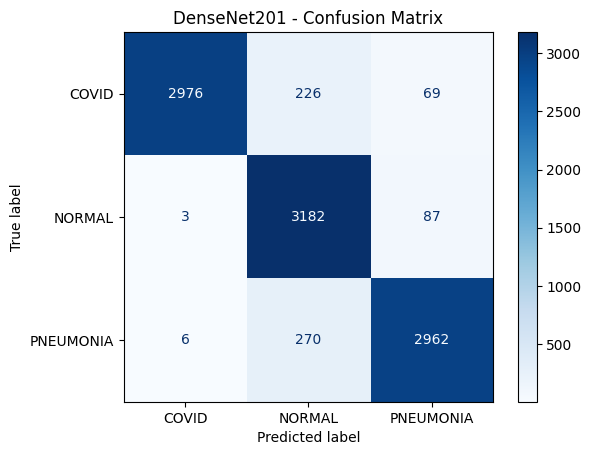


📊 Evaluating ResNet152...

306/306 ━━━━━━━━━━━━━━━━━━━━ 64s 152ms/step - accuracy: 0.8628 - loss: 0.3594
ResNet152 Test Accuracy: 86.37%
ResNet152 Test Loss: 0.3490
306/306 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step

Classification Report:
              precision    recall  f1-score   support

       COVID       0.90      0.87      0.88      3271
      NORMAL       0.83      0.86      0.85      3272
   PNEUMONIA       0.87      0.86      0.86      3238

    accuracy                           0.86      9781
   macro avg       0.86      0.86      0.86      9781
weighted avg       0.86      0.86      0.86      9781



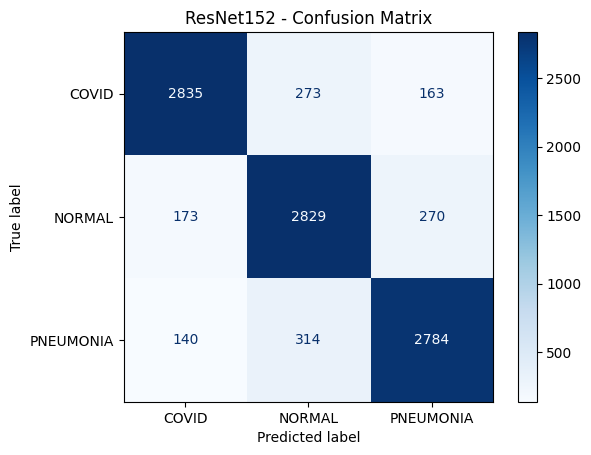

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Paths to best fine-tuned models
densenet_path = "/content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5"
resnet_path   = "/content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5"

# Load models
densenet_model = load_model(densenet_path)
resnet_model   = load_model(resnet_path)

# Evaluate function
def evaluate_model(model, test_gen, model_name):
    print(f"\n📊 Evaluating {model_name}...\n")

    # Evaluate on test set
    loss, acc = model.evaluate(test_gen, verbose=1)
    print(f"{model_name} Test Accuracy: {acc*100:.2f}%")
    print(f"{model_name} Test Loss: {loss:.4f}")

    # Predictions
    y_pred = model.predict(test_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model(densenet_model, test_gen, "DenseNet201")
evaluate_model(resnet_model, test_gen, "ResNet152")

In [ ]:
# =========================================
# SHORTCUT PIPELINE: USE EXISTING final_dataset IN DRIVE
# =========================================

# 1. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Point to your dataset in Drive
dataset_dir = "/content/drive/MyDrive/chest_xray_project/final_dataset"

# 3. Import libraries
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
img_size = (224,224)
batch_size = 32

# 4. Data generators (rescaling + augmentation for train)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\n✅ Dataset loaded successfully from Drive.")
print("Classes:", train_gen.class_indices)

# 5. Load saved models (DenseNet201 & ResNet152)
from tensorflow.keras.models import load_model

densenet_model = load_model("/content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5")
resnet_model   = load_model("/content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5")

print("\n✅ Models loaded successfully from Drive.")

# 6. Evaluate both models on test set
print("\n📊 Evaluating DenseNet201...")
densenet_model.evaluate(test_gen, verbose=1)

print("\n📊 Evaluating ResNet152...")
resnet_model.evaluate(test_gen, verbose=1)


Mounted at /content/drive
Found 32047 images belonging to 3 classes.
Found 9764 images belonging to 3 classes.
Found 9781 images belonging to 3 classes.

✅ Dataset loaded successfully from Drive.
Classes: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}



✅ Models loaded successfully from Drive.

📊 Evaluating DenseNet201...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 1632s 5s/step - accuracy: 0.9230 - loss: 0.2220

📊 Evaluating ResNet152...
306/306 ━━━━━━━━━━━━━━━━━━━━ 100s 272ms/step - accuracy: 0.8743 - loss: 0.3327


[0.34922173619270325, 0.8637153506278992]

In [ ]:
# ======================================================
# STEP 1: Download Amanullah Asraf dataset from Kaggle
# ======================================================
!kaggle datasets download -d amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset -p /content
!unzip -q /content/covid19-pneumonia-normal-chest-xray-pa-dataset.zip -d /content/amanullah_dataset

# Check dataset structure
import os
print("Dataset root contents:", os.listdir("/content/amanullah_dataset"))

Dataset URL: https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset
License(s): CC0-1.0
 99% 1.88G/1.91G [00:04<00:00, 454MB/s]
100% 1.91G/1.91G [00:04<00:00, 486MB/s]
Dataset root contents: ['pneumonia', 'normal', 'covid']


In [ ]:
# ======================================================
# STEP 2: Setup ImageDataGenerator for test set
# ======================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_dir = "/content/amanullah_dataset"  # Adjust if inside another folder
img_size = (224,224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

# Since it's a 3-class dataset (COVID, PNEUMONIA, NORMAL),
# we will use the entire dataset as a test set
external_test_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\n✅ External test dataset loaded successfully")


Found 6902 images belonging to 3 classes.

✅ External test dataset loaded successfully


In [ ]:
# ======================================================
# STEP 3: Load your trained models
# ======================================================
from tensorflow.keras.models import load_model

densenet_model = load_model("/content/drive/MyDrive/chest_xray_project/densenet201_best_ft.h5")
resnet_model   = load_model("/content/drive/MyDrive/chest_xray_project/resnet152_best_ft.h5")

print("\n✅ Models loaded from Drive")


✅ Models loaded from Drive


In [ ]:
# ======================================================
# STEP 4: Evaluate both models on the new dataset
# ======================================================
print("\n📊 Evaluating DenseNet201 on external dataset...")
densenet_model.evaluate(external_test_gen, verbose=1)

print("\n📊 Evaluating ResNet152 on external dataset...")
resnet_model.evaluate(external_test_gen, verbose=1)


📊 Evaluating DenseNet201 on external dataset...
216/216 ━━━━━━━━━━━━━━━━━━━━ 134s 483ms/step - accuracy: 0.8432 - loss: 0.4823

📊 Evaluating ResNet152 on external dataset...
216/216 ━━━━━━━━━━━━━━━━━━━━ 108s 421ms/step - accuracy: 0.7983 - loss: 0.5240


[0.40924569964408875, 0.8458417654037476]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Helper function: Error Rate
def evaluate_with_error_rate(model, generator, name="Model"):
    loss, acc = model.evaluate(generator, verbose=0)
    error_rate = 1 - acc
    print(f"\n{name} on {generator.directory.split('/')[-1]} dataset:")
    print(f" Accuracy: {acc:.4f} | Error Rate: {error_rate:.4f} | Loss: {loss:.4f}")
    return acc, error_rate, loss

# Helper function: ROC Curve (One-vs-Rest)
def plot_roc_curve(model, generator, dataset_name="Dataset"):
    y_true = generator.classes
    y_pred = model.predict(generator, verbose=0)
    class_names = list(generator.class_indices.keys())
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend(loc="lower right")
    plt.show()

# Helper function: Confusion Matrix
def plot_confusion_matrix(model, generator, name="Model"):
    y_true = generator.classes
    y_pred = model.predict(generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    labels = list(generator.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"{name} - Confusion Matrix (External Dataset)")
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=labels))

In [ ]:
# DenseNet201
evaluate_with_error_rate(densenet_model, test_gen, "DenseNet201 (Main)")
evaluate_with_error_rate(densenet_model, external_test_gen, "DenseNet201 (External)")

# ResNet152
evaluate_with_error_rate(resnet_model, test_gen, "ResNet152 (Main)")
evaluate_with_error_rate(resnet_model, external_test_gen, "ResNet152 (External)")


DenseNet201 (Main) on test dataset:
 Accuracy: 0.9323 | Error Rate: 0.0677 | Loss: 0.1898

DenseNet201 (External) on amanullah_dataset dataset:
 Accuracy: 0.8826 | Error Rate: 0.1174 | Loss: 0.3680

ResNet152 (Main) on test dataset:
 Accuracy: 0.8637 | Error Rate: 0.1363 | Loss: 0.3492

ResNet152 (External) on amanullah_dataset dataset:
 Accuracy: 0.8458 | Error Rate: 0.1542 | Loss: 0.4092


(0.8458417654037476, 0.15415823459625244, 0.40924516320228577)

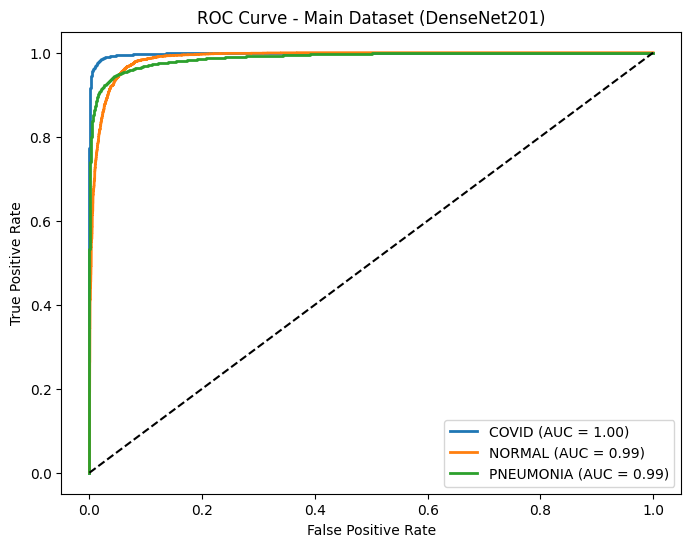

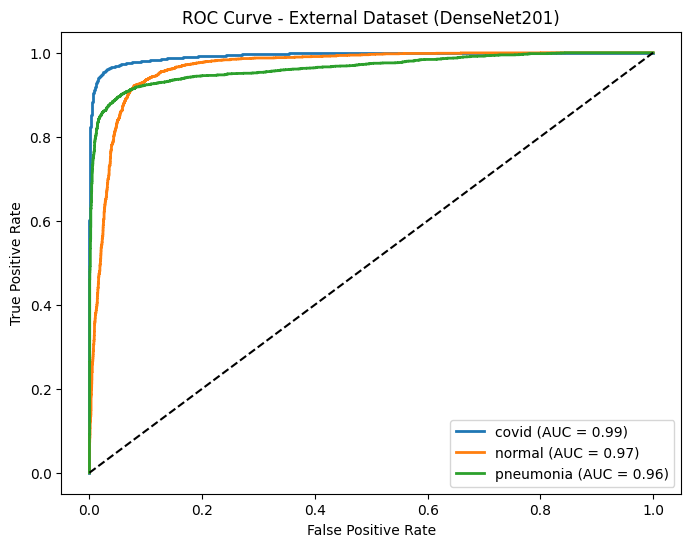

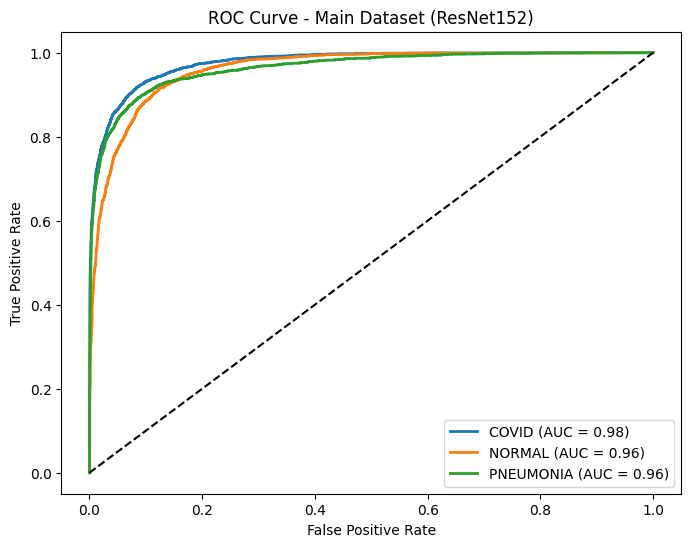

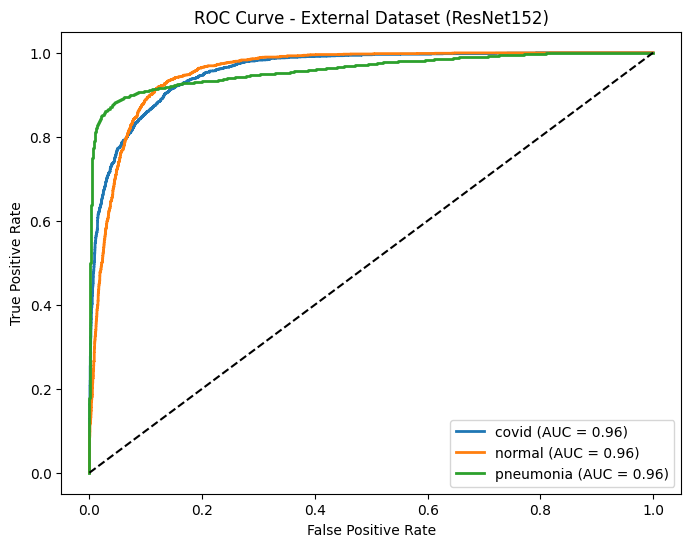

In [ ]:
# DenseNet201
plot_roc_curve(densenet_model, test_gen, "Main Dataset (DenseNet201)")
plot_roc_curve(densenet_model, external_test_gen, "External Dataset (DenseNet201)")

# ResNet152
plot_roc_curve(resnet_model, test_gen, "Main Dataset (ResNet152)")
plot_roc_curve(resnet_model, external_test_gen, "External Dataset (ResNet152)")

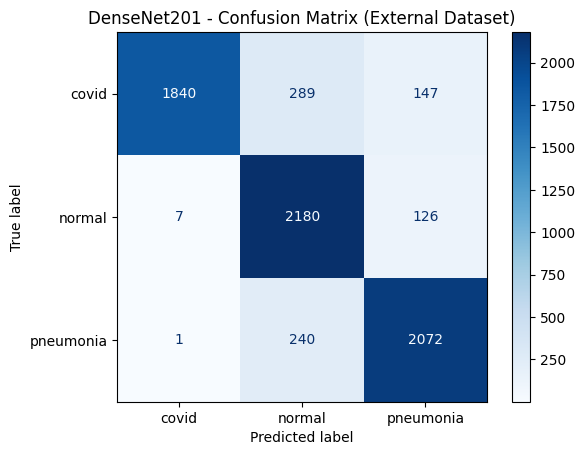


Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.81      0.89      2276
      normal       0.80      0.94      0.87      2313
   pneumonia       0.88      0.90      0.89      2313

    accuracy                           0.88      6902
   macro avg       0.89      0.88      0.88      6902
weighted avg       0.89      0.88      0.88      6902



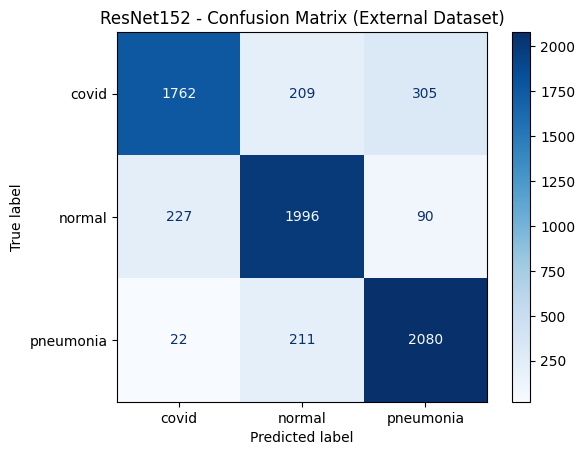


Classification Report:
              precision    recall  f1-score   support

       covid       0.88      0.77      0.82      2276
      normal       0.83      0.86      0.84      2313
   pneumonia       0.84      0.90      0.87      2313

    accuracy                           0.85      6902
   macro avg       0.85      0.85      0.85      6902
weighted avg       0.85      0.85      0.85      6902



In [ ]:
# DenseNet201
plot_confusion_matrix(densenet_model, external_test_gen, "DenseNet201")

# ResNet152
plot_confusion_matrix(resnet_model, external_test_gen, "ResNet152")

In [ ]:
import pandas as pd

def summarize_results(models, datasets, dataset_names):
    results = []
    for model, model_name in models:
        for gen, ds_name in zip(datasets, dataset_names):
            loss, acc = model.evaluate(gen, verbose=0)
            error_rate = 1 - acc

            # AUC (macro average across classes)
            y_true = gen.classes
            y_pred = model.predict(gen, verbose=0)
            y_true_bin = label_binarize(y_true, classes=range(len(gen.class_indices)))
            aucs = []
            for i in range(y_true_bin.shape[1]):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
                aucs.append(auc(fpr, tpr))
            auc_avg = np.mean(aucs)

            results.append({
                "Model": model_name,
                "Dataset": ds_name,
                "Accuracy": round(acc*100, 2),
                "Error Rate": round(error_rate*100, 2),
                "Loss": round(loss, 4),
                "Avg AUC": round(auc_avg, 4)
            })
    return pd.DataFrame(results)

# Define models and datasets
models = [(densenet_model, "DenseNet201"), (resnet_model, "ResNet152")]
datasets = [test_gen, external_test_gen]
dataset_names = ["Main Dataset", "External Dataset"]

# Generate summary table
summary_df = summarize_results(models, datasets, dataset_names)
import IPython.display as display
display.display(summary_df)

,Model,Dataset,Accuracy,Error Rate,Loss,Avg AUC
0,DenseNet201,Main Dataset,93.23,6.77,0.1898,0.9916
1,DenseNet201,External Dataset,88.26,11.74,0.3680,0.9742
2,ResNet152,Main Dataset,86.37,13.63,0.3492,0.9665
3,ResNet152,External Dataset,84.58,15.42,0.4092,0.9573
